In [1]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 0.8.1+271.g07de215c
Numpy version: 1.24.4
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 07de215caf79dabec20ac53fb38d9f2df36f182a
MONAI __file__: /root/miniconda3/envs/swim/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.0
Tensorboard version: 1.15.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/insta

/root/miniconda3/envs/swim/lib/python3.8/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  (np.object, string),


In [2]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def datafold_read(datalist, basedir, fold=0, key="training"):
    with open(datalist) as f:
        json_data = json.load(f)

    json_data = json_data[key]

    for d in json_data:
        for k in d:
            if isinstance(d[k], list):
                d[k] = [os.path.join(basedir, iv) for iv in d[k]]
            elif isinstance(d[k], str):
                d[k] = os.path.join(basedir, d[k]) if len(d[k]) > 0 else d[k]

    tr = []
    val = []
    for d in json_data:
        if "fold" in d and d["fold"] == fold:
            val.append(d)
        else:
            tr.append(d)

    return tr, val


# def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add=root_dir):
#     state_dict = model.state_dict()
#     save_dict = {"epoch": epoch, "best_acc": best_acc, "state_dict": state_dict}
#     filename = os.path.join(dir_add, filename)
#     torch.save(save_dict, filename)
#     print("Saving checkpoint", filename)

In [3]:
in_modalities = ["T1","T1c","Flair"]
modalities_indices = [i for i, modality in enumerate(["Flair", "T1", "T1c", "T2"]) if modality in in_modalities]
modalities_indices

[0, 1, 2]

image shape: (240, 240, 155), label shape: (240, 240, 155)


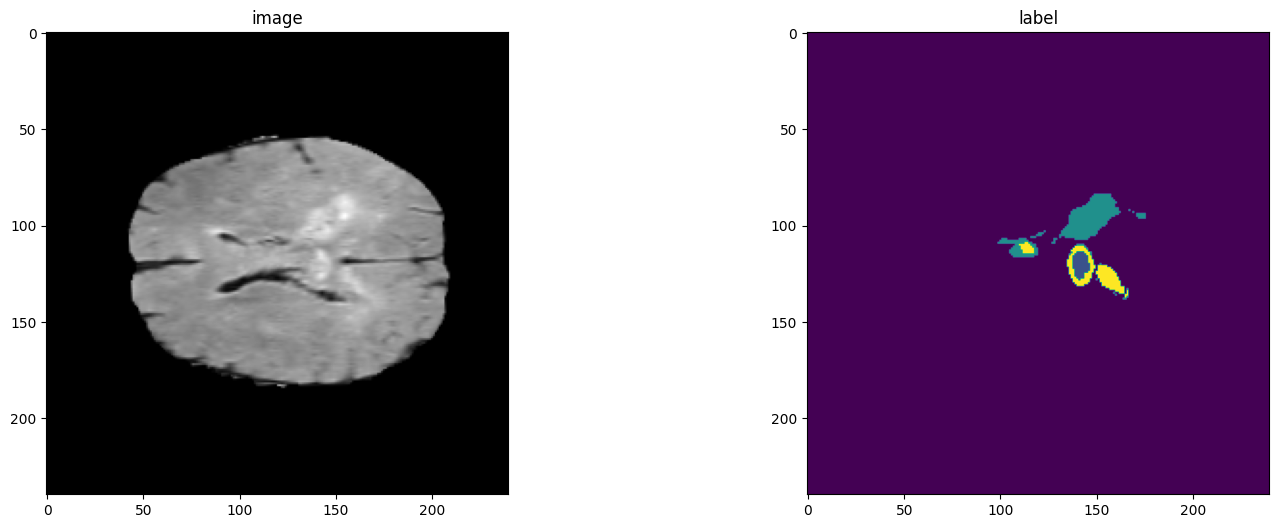

In [4]:
data_dir = "/root/autodl-tmp/BraTs2018/BraTs2018/MICCAI_BraTS_2018_Data_Training/HGG/"
floor = 89
img_add = os.path.join(data_dir, "/root/autodl-tmp/BraTs2018/BraTs2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_2_1/Brats18_2013_2_1_flair.nii")
label_add = os.path.join(data_dir, "/root/autodl-tmp/BraTs2018/BraTs2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_2_1/Brats18_2013_2_1_seg.nii")
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
print(f"image shape: {img.shape}, label shape: {label.shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[:, :, floor], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, floor])
plt.show()

In [5]:
from typing import Tuple
def mask_rand_patch(
    window_sizes: Tuple[int, int, int], input_sizes: Tuple[int, int, int], mask_ratio: float, samples: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    """Patch-wise random masking."""
    if len(window_sizes) != len(input_sizes) or any(
        [input_size % window_size != 0 for window_size, input_size in zip(window_sizes, input_sizes)]
    ):
        raise ValueError(f"{window_sizes} & {input_sizes} is not compatible.")

    mask_shape = [input_size // window_size for input_size, window_size in zip(input_sizes, window_sizes)]
    num_patches = np.prod(mask_shape).item()
    mask = np.ones(num_patches, dtype=bool)
    indices = np.random.choice(num_patches, round(num_patches * mask_ratio), replace=False)
    mask[indices] = False
    mask = mask.reshape(mask_shape)
    wh, ww, wd = window_sizes
    mask = np.logical_or(mask[:, None, :, None, :, None], np.zeros([1, wh, 1, ww, 1, wd], dtype=bool)).reshape(
        input_sizes
    )
    mask = torch.from_numpy(mask).to(samples.device)

    res = samples.detach().clone()
    res[:, :, mask] = 0
    return res, mask


In [6]:
window_size = 16
roi_x,roi_y,roi_z = 128,128,128
window_sizes = tuple(window_size for _ in range(3))
input_sizes = (roi_x, roi_y, roi_z)


In [9]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roi = (128, 128, 128)
# model = SwinUNETR(
#     img_size=roi,
#     in_channels=4,
#     out_channels=3,
#     feature_size=48,
#     drop_rate=0.0,
#     attn_drop_rate=0.0,
#     dropout_path_rate=0.0,
#     use_checkpoint=True,
# ).to(device)
from models.SimMIM import SSLHead
model = SSLHead(
        img_size=roi,
        in_channels=2,
        out_channels=4,
        feature_size=48,
        use_checkpoint=True,
        upsample='vae'
    ).to(device)

In [10]:
model.load_state_dict(torch.load("/root/SwimUNETR_miss/BraTS2018/runs/pre_masked_flair_t1/model_final.pt")["state_dict"])
model.to(device)
model.eval()

SSLHead(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(2, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_features=

In [9]:
# # root_dir = "/root/SwinUNETR/BRATS21/runs/test"
# root_dir = "/root/SwimUNETR_miss/pretrained_models"
# model.load_state_dict(torch.load(os.path.join(root_dir, "model.pt"))["state_dict"])
# model.to(device)
# model.eval()

In [11]:
case_num = "2013_2_1"
# /root/autodl-tmp/BraTs2018/BraTs2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_2_1
test_files = [
    {
        "image": [
            os.path.join(
                data_dir,
                "Brats18_" + case_num + "/Brats18_" + case_num + "_flair.nii",
            ),
            os.path.join(
                data_dir,
                "Brats18_" + case_num + "/Brats18_" + case_num + "_t1ce.nii",
            ),
            os.path.join(
                data_dir,
                "Brats18_" + case_num + "/Brats18_" + case_num  + "_t1.nii",
            ),
            os.path.join(
                data_dir,
                "Brats18_" + case_num + "/Brats18_" + case_num + "_t2.nii",
            ),
        ],
        "label": os.path.join(
            data_dir,
            "Brats18_" + case_num + "/Brats18_" + case_num + "_seg.nii",
        ),
    }
]

test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        # transforms.RandSpatialCropd(
        #         keys=["image", "label"], roi_size=[roi_x, roi_y, roi_z], random_size=False
        #     ),
    ]
)

test_ds = data.Dataset(data=test_files, transform=test_transform)

test_loader = data.DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

In [12]:
with torch.no_grad():
    for batch_data in test_loader:
        image_f = batch_data["image"].cuda()
        image = image_f[:,[0],:,:,:]
        x1_masked, mask1 = mask_rand_patch(window_sizes, input_sizes, 0.5, image)
        rec = model.forward(x1_masked)
        break 

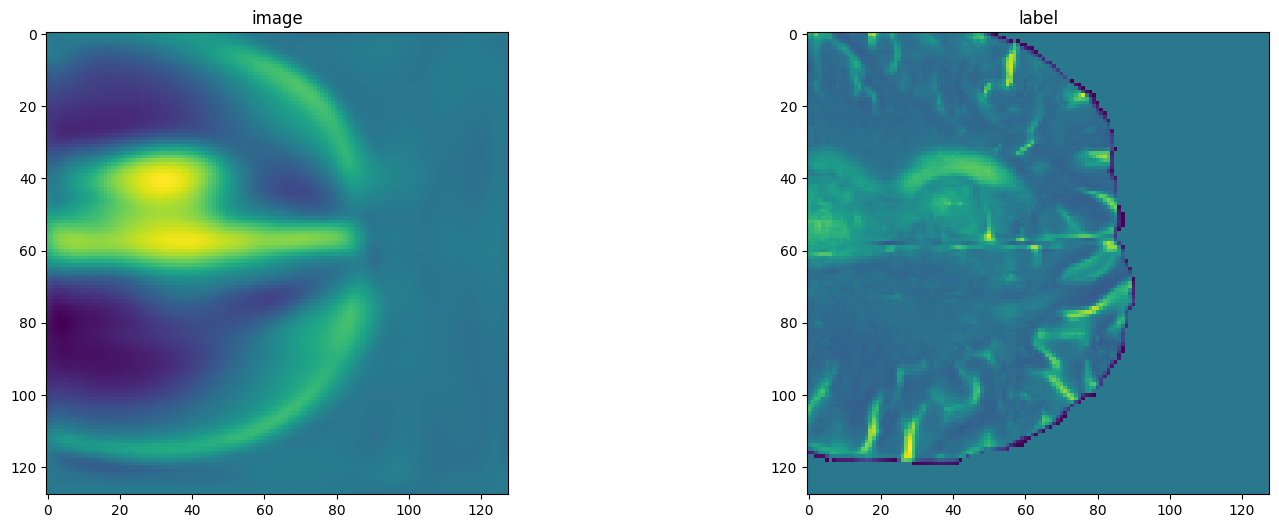

In [15]:
img = image_f[0,:,:,:,:].detach().cpu().numpy()
img_rec = rec[0,:,:,:,:].detach().cpu().numpy()
img_masked = x1_masked[0,:,:,:,:].detach().cpu().numpy()
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img_rec[3,:, :, floor])
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(img[3,:, :, floor])
plt.show()

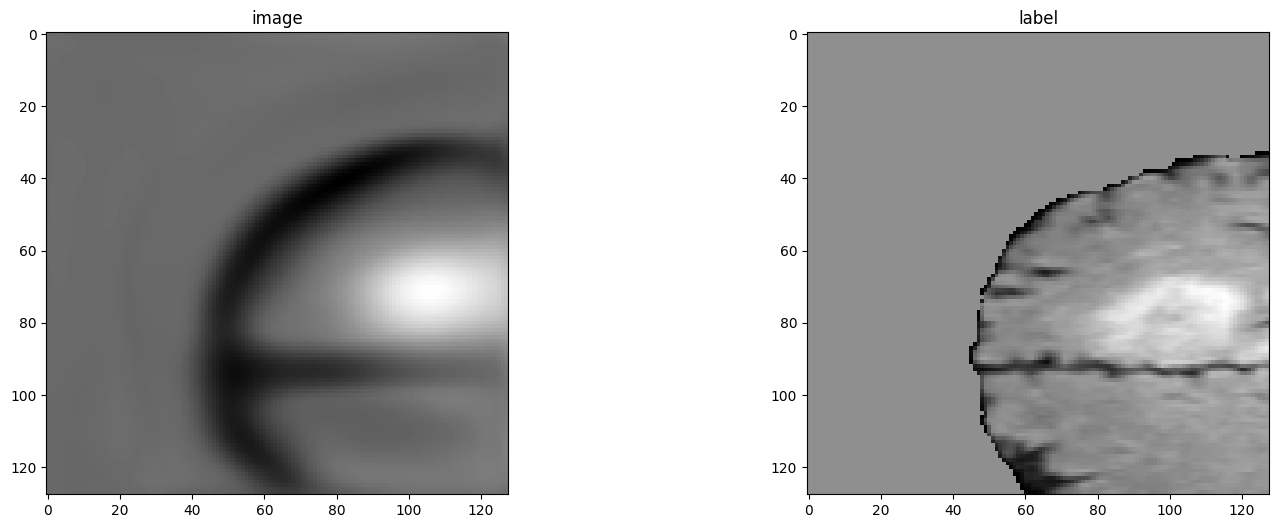

In [13]:
img = image_f[0,:,:,:,:].detach().cpu().numpy()
img_rec = rec[0,:,:,:,:].detach().cpu().numpy()
img_masked = x1_masked[0,:,:,:,:].detach().cpu().numpy()
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img_rec[0,:, :, floor], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(img[0,:, :, floor], cmap="gray")
plt.show()

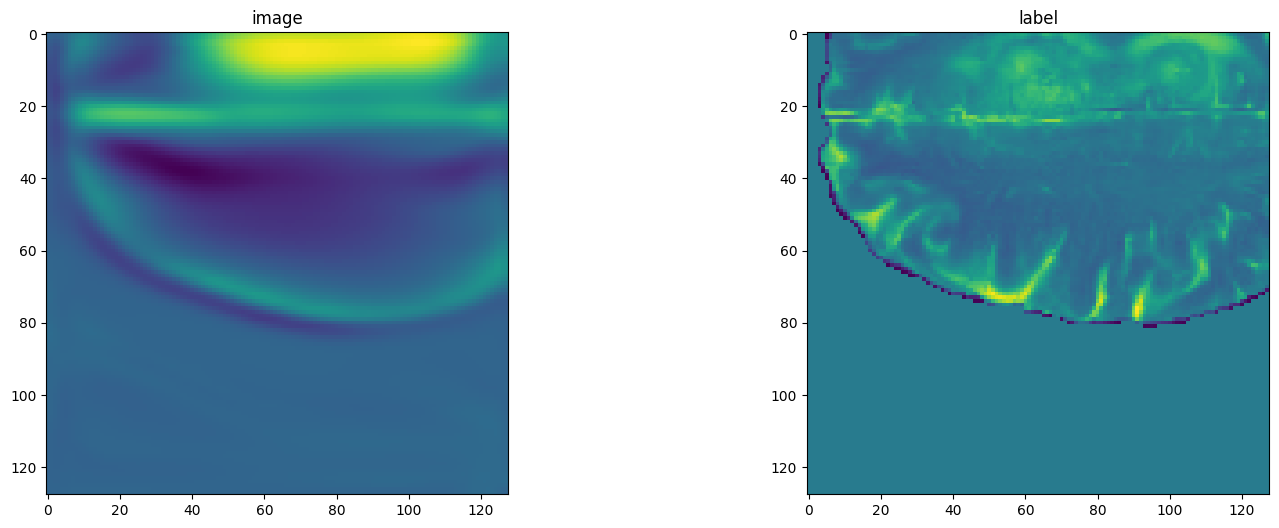

In [13]:
img = image_f[0,:,:,:,:].detach().cpu().numpy()
img_rec = rec[0,:,:,:,:].detach().cpu().numpy()
img_masked = x1_masked[0,:,:,:,:].detach().cpu().numpy()
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img_rec[3,:, :, floor])
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(img[3,:, :, floor])
plt.show()

In [18]:
img[0,:, :, floor]

array([[-0.17469068, -0.07084709,  0.01411583, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07084709, -0.04252612, -0.03308579, ...,  0.        ,
         0.        ,  0.        ],
       [-0.07084709, -0.04252612, -0.00476482, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [20]:
print(img_masked[0,:, :, floor])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [13]:
model_inferer_test = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],
    sw_batch_size=1,
    predictor=model,
    overlap=0.6,
)
with torch.no_grad():
    for batch_data in test_loader:
        image_f = batch_data["image"].cuda()
        image = image_f[:,0:2,:,:,:]
        pred = model_inferer_test(image)
        break 
        prob = torch.sigmoid(model_inferer_test(image))
        seg = prob[0].detach().cpu().numpy()
        seg = (seg > 0.5).astype(np.int8)
        seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
        seg_out[seg[1] == 1] = 2
        seg_out[seg[0] == 1] = 1
        seg_out[seg[2] == 1] = 4

/root/miniconda3/envs/swim/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


torch.Size([1, 1, 240, 240, 155])

In [15]:
image_s = image_f[0,:,:,:,:].detach().cpu().numpy()
image_s.shape 
pred_s = pred[0,:,:,:,:].detach().cpu().numpy()

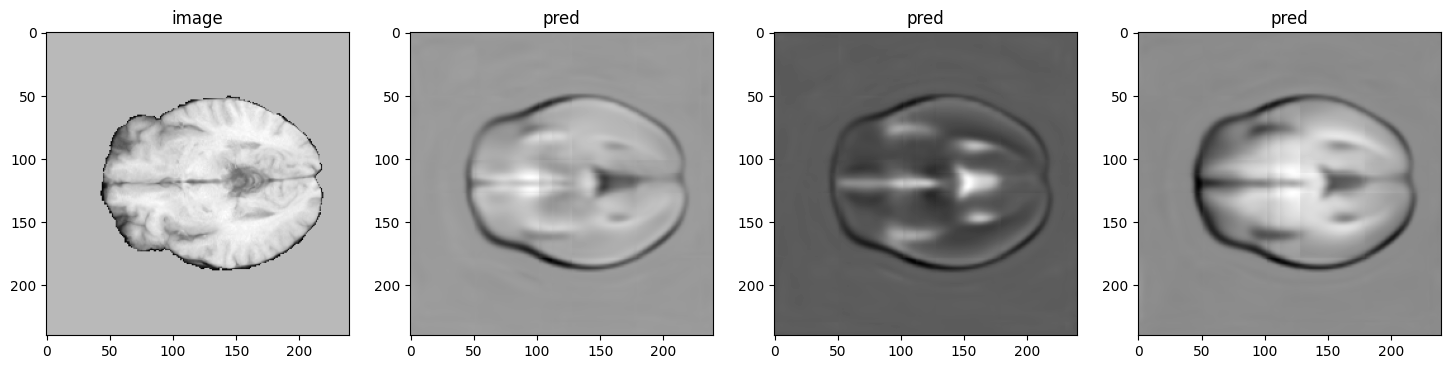

In [16]:
slice_num = 67
plt.figure("image", (18, 6))
plt.subplot(1, 4, 1)
plt.title("image")
plt.imshow(image_s[2,:, :, slice_num], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("pred")
plt.imshow(pred_s[0,:, :, slice_num], cmap="gray")
plt.subplot(1, 4, 3)
plt.title("pred")
plt.imshow(pred_s[3,:, :, slice_num], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("pred")
plt.imshow(pred_s[1,:, :, slice_num], cmap="gray")


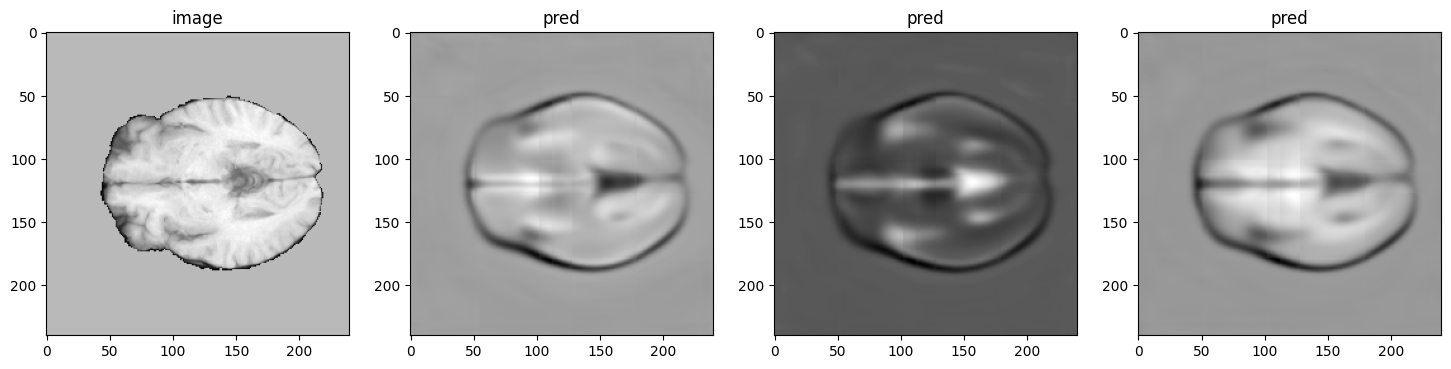

In [17]:
slice_num = 67
plt.figure("image", (18, 6))
plt.subplot(1, 4, 1)
plt.title("image")
plt.imshow(image_s[2,:, :, slice_num], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("pred")
plt.imshow(pred_s[0,:, :, slice_num], cmap="gray")
plt.subplot(1, 4, 3)
plt.title("pred")
plt.imshow(pred_s[3,:, :, slice_num], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("pred")
plt.imshow(pred_s[1,:, :, slice_num], cmap="gray")


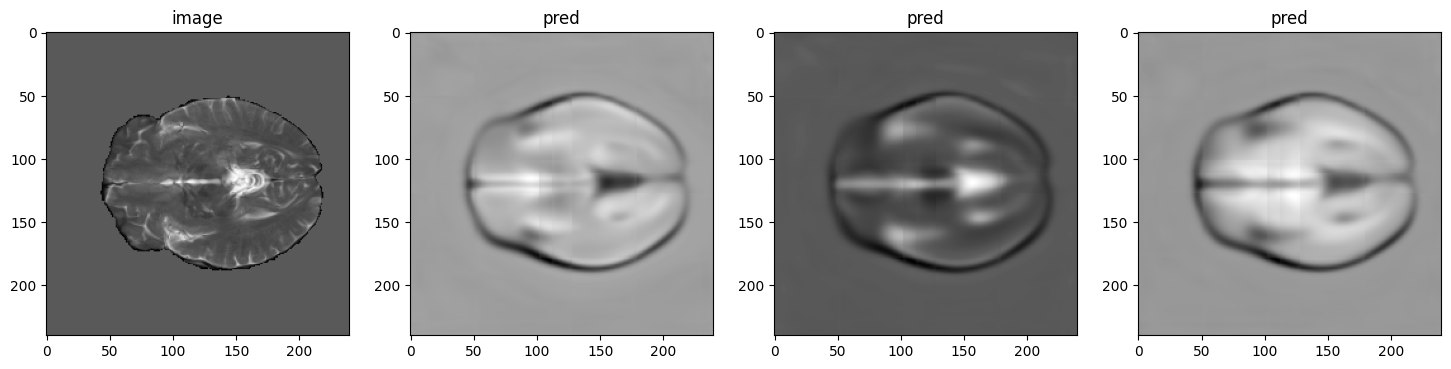

In [19]:
slice_num = 67
plt.figure("image", (18, 6))
plt.subplot(1, 4, 1)
plt.title("image")
plt.imshow(image_s[3,:, :, slice_num], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("pred")
plt.imshow(pred_s[0,:, :, slice_num], cmap="gray")
plt.subplot(1, 4, 3)
plt.title("pred")
plt.imshow(pred_s[3,:, :, slice_num], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("pred")
plt.imshow(pred_s[1,:, :, slice_num], cmap="gray")


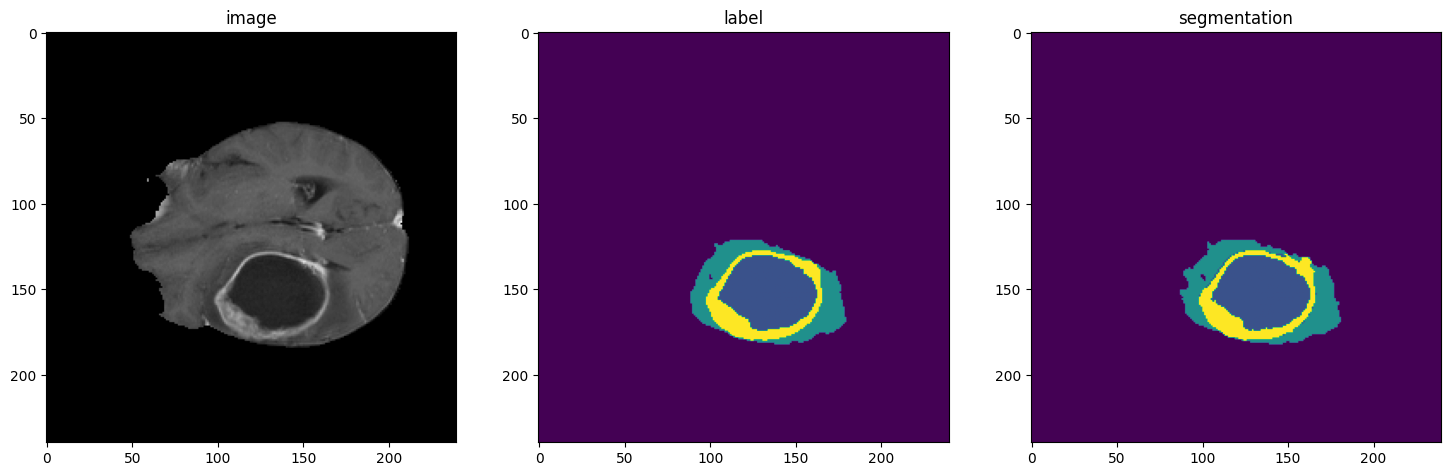

In [8]:
slice_num = 67
img_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_t1ce.nii.gz",
)
label_add = os.path.join(
    data_dir,
    "TrainingData/BraTS2021_" + case_num + "/BraTS2021_" + case_num + "_seg.nii.gz",
)
img = nib.load(img_add).get_fdata()
label = nib.load(label_add).get_fdata()
plt.figure("image", (18, 6))
plt.subplot(1, 3, 1)
plt.title("image")
plt.imshow(img[:, :, slice_num], cmap="gray")
plt.subplot(1, 3, 2)
plt.title("label")
plt.imshow(label[:, :, slice_num])
plt.subplot(1, 3, 3)
plt.title("segmentation")
plt.imshow(seg_out[:, :, slice_num])
plt.show()

In [14]:
model.swinViT.state_dict()['layers4.0.downsample.norm.weight']

tensor([0.9827, 1.0070, 1.1079,  ..., 1.0758, 1.0772, 1.0926], device='cuda:0')

In [17]:
torch.save({"state_dict":model.swinViT.state_dict()}, "pretrained_models/pre_train_masked_flair_t1.pt")

In [17]:
torch.load( "pretrained_models/pre_train_swinVit_multista_singal2three.pt")['state_dict']['layers4.0.downsample.norm.weight']

tensor([0.9827, 1.0070, 1.1079,  ..., 1.0758, 1.0772, 1.0926], device='cuda:0')